# Generative Adversarial Networks

This notebook exemplifies the Generative Adversarial Nets

Ref.: Goodfellow, et. al. 
      https://arxiv.org/pdf/1406.2661
      
      
This notebooks implements a generative adversarial net and illustrate it for the (simplest) case
that the model generates a random gaussian-distributed random variable from a uniformly draw random
latend vector (which is one-dimensional).

An interactive plot visualises how the network learns, i.e., how the discriminator and the generator 
competes. The discriminator tries to predict whether a given example is from the real data or from
the generator. The generator, however, tries to trick the discriminator. For this it lears the 
distribution of the real data.

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as lines

from show_graph import show  # This allows to show the graph

# The model


In [2]:
def lazy_property(function):
    """ decorator that stores the propery after its first call
    """
    attr_name = '_cached_' + function.__name__

    @property
    def _lazy_property(self):
        if not hasattr(self, attr_name):
            setattr(self, attr_name, function(self))
        return getattr(self, attr_name)
    
    _lazy_property.__doc__ = function.__doc__
    return _lazy_property


def scoped(function):
    """ decorator that covers the function in a tf.Scope
    """
    
    tensorname = function.__name__
    
    def scoped_function(self):
        with tf.variable_scope(tensorname):
            tensor = function(self)
        return tensor
    
    scoped_function.__name__ = function.__name__
    scoped_function.__doc__ = function.__doc__
    return scoped_function

def multi_layer_perceptron(inputs, hidden_layer_sizes, output_dim, reuse=None):
    """ generates a (fully-connected) multi-layer perceptron
    
    Args:
        inputs (tf.Tensor): the inputs of the network, at least two dimensions
            where the last one is the dimension of the inputs
        hidden_layer_sizes (list of int): the number of units in each layer
        output_dim: the dimension of the output
        reuse (bool): if True, the tf.Varialbes are shared in the scope
        
    Returns:
        tf.Tensor of shape as inputs, but with the last dimension given by
            output_dim
    """
    layer = inputs
    for i, units in enumerate(hidden_layer_sizes):
        with tf.variable_scope(f'layer_{i}'):
            layer = tf.layers.dense(layer, units, activation=tf.nn.sigmoid,
                                    reuse=reuse)
    with tf.variable_scope(f'output'):
        layer = tf.layers.dense(layer, output_dim, reuse=reuse, activation=tf.nn.sigmoid)
    return layer

The following is the implementation of the network. Its graph is illustated below.

In [3]:

class GenerativeAdversarialNetworks:
    """Generative Adversarial Networks
    
    Args:
        data_batch (tf.Tensor [data_batch_size, data_dim]): the batch of (real)
            data which the model shall try to reproduce
        data_batch_size (tf.Placeholder): the batch size of data_batch
        build_generator (func(inputs: tf.Tensor, output_dim: int)) -> tf.Tensor:
            this function builds the generator, where `inputs` is a 
            tf.Tensor (the random variable) of shape (None, output_dim)
            and output_dim shall defines the shape (None, output_dim) of the 
            builded tensor.
        build_generator (func(inputs: tf.Tensor, reuse: bool)) -> tf.Tensor:
            this function builds the descriminator, where `inputs` is a 
            tf.Tensor (either the generator or the data_batch) each of shape 
            (None, output_dim). The builded tensor must have shape of (None, 1)
            
    Attributes:
        self.data_batch (tf.Tensor): the batch of (real) data
        self.data_batch_size (tf.Placeholder): the batch size of data_batch
    """
    BATCH_SIZE = None
    NOISE_DIM = 1
    LEARNING_RATE_DISCRIMINATOR = 0.001
    LEARNING_RATE_GENERATOR = 0.001
    DISCRIMINATOR_SCOPE = 'discriminator'
    GENERATOR_SCOPE = 'generator'
    
    @lazy_property
    @scoped
    def noise_batch_size(self):
        """ tf.Placeholder: providing the first dimension of the noise_prior"""
        return tf.placeholder(tf.int32, name="noise_batch_size", shape=[])

    def __init__(self, data_batch, data_batch_size,
                 build_generator, build_discriminator):
        self.data_batch = data_batch
        self.data_dim = self.data_batch.get_shape()[1]
        self.data_batch_size = data_batch_size
        with tf.variable_scope(self.GENERATOR_SCOPE):
            self.generator = build_generator(self.noise_prior, self.data_dim)
        with tf.variable_scope(self.DISCRIMINATOR_SCOPE):
            self.discriminator = [build_discriminator(self.data_batch),
                                  build_discriminator(self.generator, reuse=True)]
        self._build()
        
    def _build(self):
        self.train_op_discriminator
        self.train_op_generator

    @lazy_property
    @scoped
    def noise_prior(self):
        """tf.Tensor: the noise prior used by the generator"""
        return tf.random_uniform([self.noise_batch_size, self.NOISE_DIM])
        
    @lazy_property
    @scoped
    def correct_assignment_for_real_data(self):
        return -tf.reduce_mean(tf.log(self.discriminator[0]))

    
    @lazy_property
    @scoped
    def correct_assignment_for_generated_data(self):
        return -tf.reduce_mean(tf.log(1 - self.discriminator[1]))
    
    @lazy_property
    @scoped
    def correct_assignment(self):
        return (self.correct_assignment_for_real_data + 
                self.correct_assignment_for_generated_data)/2
    
    @lazy_property
    @scoped
    def test(self):
        return - tf.reduce_mean(tf.log(self.discriminator[1]))

    @lazy_property
    @scoped
    def train_op_discriminator(self):
        """tf.Operation: performs one SGD on the discriminator"""
        train_var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                                            scope=self.DISCRIMINATOR_SCOPE)
        optimizer = tf.train.AdamOptimizer(
            learning_rate=self.LEARNING_RATE_DISCRIMINATOR)
        return optimizer.minimize(
            self.correct_assignment,
            var_list=train_var_list)
    
    
    @lazy_property
    @scoped
    def train_op_generator(self):
        """tf.Operation: performs one SGD on the generator"""  
        train_var_list = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, 
            scope=self.GENERATOR_SCOPE)
        optimizer = tf.train.AdamOptimizer(
            learning_rate=self.LEARNING_RATE_GENERATOR)
        return optimizer.minimize(
            self.test,
            var_list=train_var_list)

def build_generator(inputs, output_dim, reuse=None):
    return multi_layer_perceptron(inputs, [10, 20, 10], output_dim, reuse=reuse)

def build_discriminator(inputs, reuse=None):
    return multi_layer_perceptron(inputs, [10, 20, 10], 1, reuse=reuse)

In [4]:
tf.reset_default_graph()
with tf.variable_scope("data"):
    data_batch_size = tf.placeholder(tf.int32, name="batch_size", shape=[])
    data_batch = tf.random_normal(shape=[data_batch_size, 1], stddev=0.1, mean=0.3)
model = GenerativeAdversarialNetworks(data_batch, data_batch_size,
                                      build_generator, build_discriminator)

The discriminator gets samples from either the data and the generator. The train_op_generator improves the generator such that the discriminator wrongly determines that its source are the data. The train_op_discriminator improves the accuracy of the discriminator.

In [5]:
show()

In [6]:
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())

In [7]:
class InteractivePlot:
    """ Interactive plot which monitors the training progress
    
    Two panels are shown. The upper panel shows the data
    generating distribution, the generative distribution, and
    the discriminative distrubtion. The lower panel shows the
    mapping from the noise to the sample.

    """
    def __init__(self, x, z, data_distribution):
        """
        Args:
            x (array): the common x-value for all signals
            signal (array like x): the data generating distribution
            target (array like x): generative distribution
            prediction_init (array like x): initial prediction to
                shown in lower panel. This can be updated via update()
        """
        plt.ion()
        self.fig = plt.figure()
        
        self.x = x
        self.z = z
        
        # upper subplot
        ax_distribution = plt.subplot(211)
        ax_distribution.set_ylabel("probability p")
        ax_distribution.set_xlim(min(x), max(x))
        ax_distribution.set_ylim(0, 5)
        
        # lower sybplot
        ax_generator_map = plt.subplot(212, sharex=ax_distribution)
        ax_generator_map.set_xlim(min(x), max(x))
        ax_generator_map.set_ylim(0, 1)
        ax_generator_map.set_xlabel("data space x")
        ax_generator_map.set_ylabel("noise z")
    
        # lines
        self.data_distribution = self._new_line_in_subplot(
            ax_distribution, args={'c': 'k', 'label': "data generating distribution"})
        self.data_distribution.set_xdata(x)
        self.data_distribution.set_ydata(data_distribution)
        
        self.generator_map = self._new_line_in_subplot(
            ax_generator_map,  args={'c': 'b', 'label': "mapping G(z): noise z to data x"}) 
        
        self.generative_distribution = self._new_line_in_subplot(
            ax_distribution, args={'c': 'b', 'label': "generative distribution"})
        
        self.discriminator = self._new_line_in_subplot(
            ax_distribution, args={'c': 'g', 'label': "discriminative distribution D"})
        
      
        ax_distribution.legend()
        ax_generator_map.legend()
        #plt.show()        
        self.fig.canvas.draw()

        
    @classmethod    
    def _new_line_in_subplot(cls, subplot, args):
        line = lines.Line2D([], [], **args)
        subplot.add_line(line)
        return line

    def update(self, generative_distribution, discriminative_distribution):
        """ updates the distrubtions
        
        Args:
            generative_distribution:
            discriminative_distribution: 
        """
        self.generator_map.set_ydata(self.z)
        self.discriminator.set_xdata(self.x)
        tmp = np.zeros(len(generative_distribution)+1)
        tmp[0] = generative_distribution[0]
        tmp[-1] = generative_distribution[-1]
        tmp[1:-1] = (generative_distribution[1:] + generative_distribution[:-1])/2
        self.generative_distribution.set_xdata(tmp)
            
        
        self.discriminator.set_ydata(discriminative_distribution)
        self.generator_map.set_xdata(generative_distribution)
        
        tmp = np.zeros(len(generative_distribution)+1)
        tmp[0] = 0
        tmp[-1] = 0
        tmp[1:-1] = abs(np.diff(self.x)/np.diff(generative_distribution))

        
        
        self.generative_distribution.set_ydata(tmp)
        generative_distribution
        self.fig.canvas.draw()

In [8]:
def plot():
    
    x = np.linspace(0,1,128)
    z = np.linspace(0,1,128)

    generator_map, [discriminator, _] = session.run(
        [model.generator, model.discriminator],
        feed_dict={model.noise_prior: np.expand_dims(iplot.z, axis=1),
                   model.data_batch: np.expand_dims(iplot.x, axis=1)})

    iplot.update(discriminative_distribution=discriminator,
                 generative_distribution=generator_map.reshape(-1))

The generative distribution approaches the data generating distribution. Note that it does not apprach completely since 

<IPython.core.display.Javascript object>


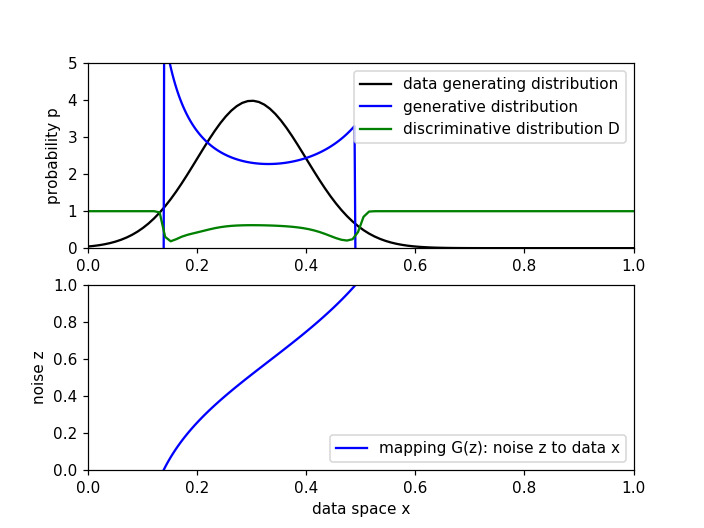

In [9]:
def gaussian(x, mean, std_dev):
    """ a gaussian function with mean and standard deviation str_dev"""
    return 1/((2*np.pi)**0.5*std_dev)*np.exp(-(x-mean)**2/std_dev**2/2)

x=np.linspace(0, 1, 100)

%matplotlib notebook
iplot = InteractivePlot(
    x=x,
    z=np.linspace(0, 1, 100),
    data_distribution=gaussian(x, 0.3, 0.1))

for i in range(3000):
    for _ in range(20):
        session.run(model.train_op_discriminator, 
                    feed_dict={model.noise_batch_size: 64,
                               model.data_batch_size: 64})
    session.run(model.train_op_generator,
                feed_dict={model.noise_batch_size: 64,
                           model.data_batch_size: 64})
    if i % 10 == 0:
        plot()

# Conclusion

We habe trained a GAN, i.e., a generator which generates data which looks like the one from the real data distribution from the training data.